In [1]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import train_val_loader, test_loader
from networks.cnn import CNN, CNN_pool
from networks.tests import VisionTransformer
import matplotlib.pyplot as plt
import pyreadr

# Results for Brown-Resnick with new parameter range

## PL

In [2]:
exp = "exp_3"
path = f'../data/{exp}/data/'
brown_params = pyreadr.read_r(path+"brown_test_params.RData")["test_params"].to_numpy()
schlather_params = pyreadr.read_r(path+"powexp_test_params.RData")["test_params"].to_numpy()
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit_opt.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"powexp_single_image_fit_opt.RData")["results"].to_numpy()[:,1:]

In [3]:
#Brown results
res = brown_params-brown_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(np.round(rmse,2))
print(np.round(mae,2))
print(np.round(np.mean(res, axis = 0),2))

[5.69095e+03 6.90000e-01]
[6.199e+02 4.300e-01]
[-6.1966e+02  3.3000e-01]


In [4]:
#Schlather results
res = schlather_params-schlather_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(np.round(rmse,2))
print(np.round(mae,2))
print(np.round(np.mean(res, axis = 0),2))

[1.78 0.86]
[1.55 0.68]
[1.5  0.47]


In [15]:
# Dataloader
exp = "exp_3"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 750)

In [24]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/cnn_{model}.pt"))

<All keys matched successfully>

In [17]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [18]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:, 0] = -(1/0.25)*np.log(params[:,0])
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [19]:
def get_metrics(pred_tf, param_tf):
    rmse = np.sqrt(np.mean((np.power(pred_tf-param_tf,2)), axis = 0))
    mae = np.mean(np.abs(pred_tf-param_tf), axis = 0)
    bias = np.mean(pred_tf-param_tf, axis = 0)
    print(f"RMSE: {np.round(rmse,2)}")
    print(f"MAE: {np.round(mae,2)}")
    print(f"Bias: {np.round(bias,2)}")

In [20]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [21]:
# Brown metrics
get_metrics(pred_tf,param_tf)

RMSE: [1.77 0.27]
MAE: [1.08 0.18]
Bias: [ 0.96 -0.03]


In [22]:
# Plot results
n_comb = 25
n_each = 30

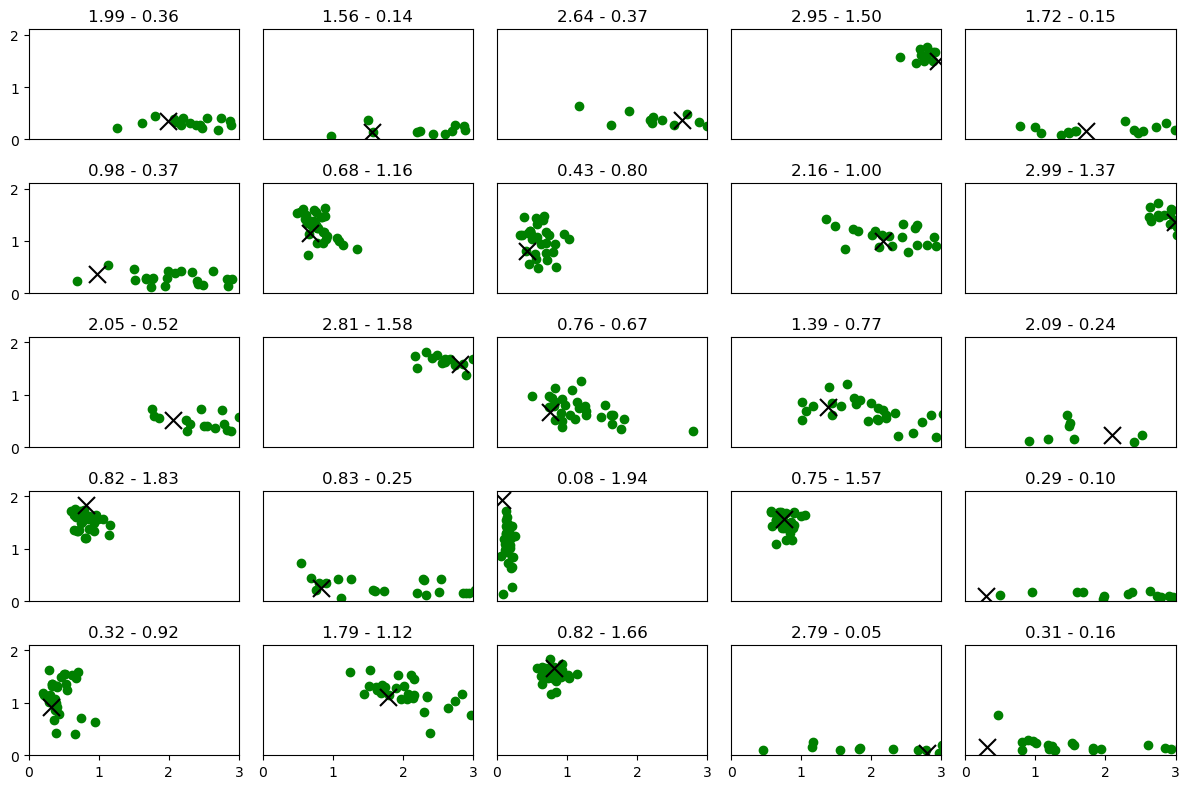

In [23]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2.1])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

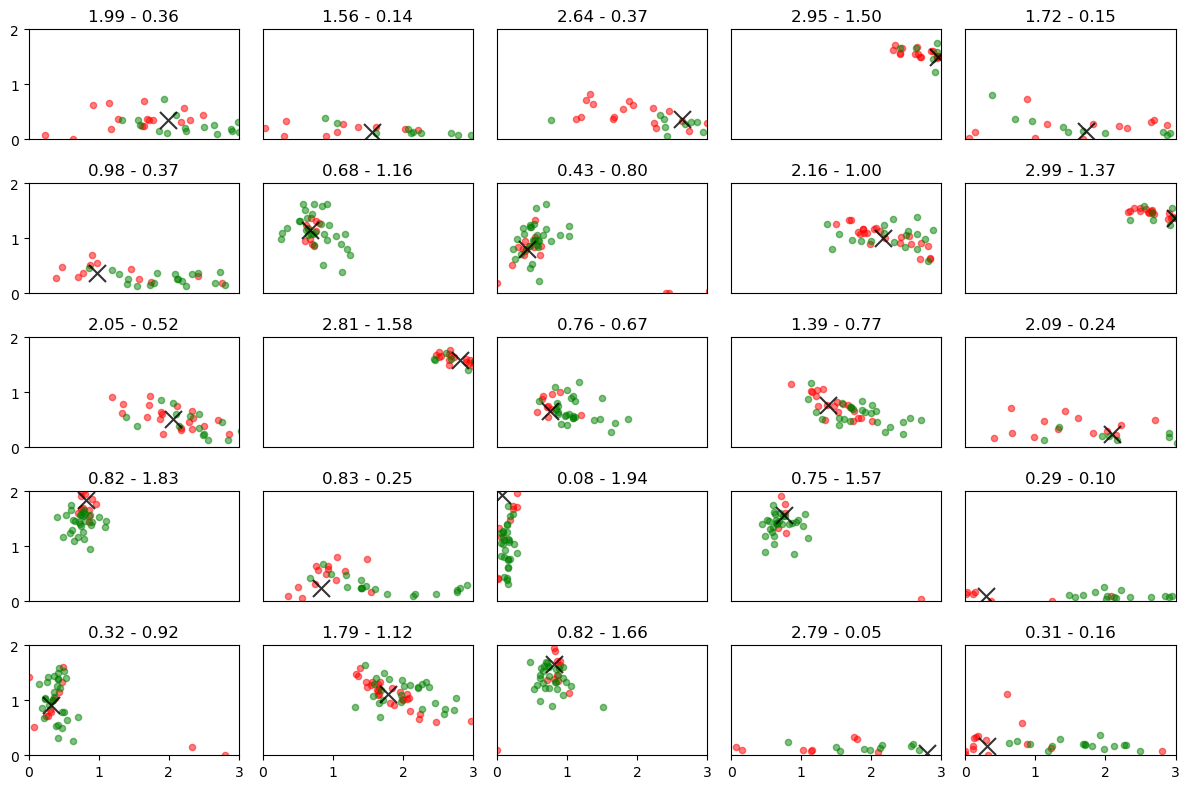

In [14]:
# With Likelihood fixed range

range_1 = 3
range_2 = 2
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*n_each):((i+1)*n_each),0], y = brown_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_xlim([0,range_1])
    axs[i].set_ylim([0,range_2])
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

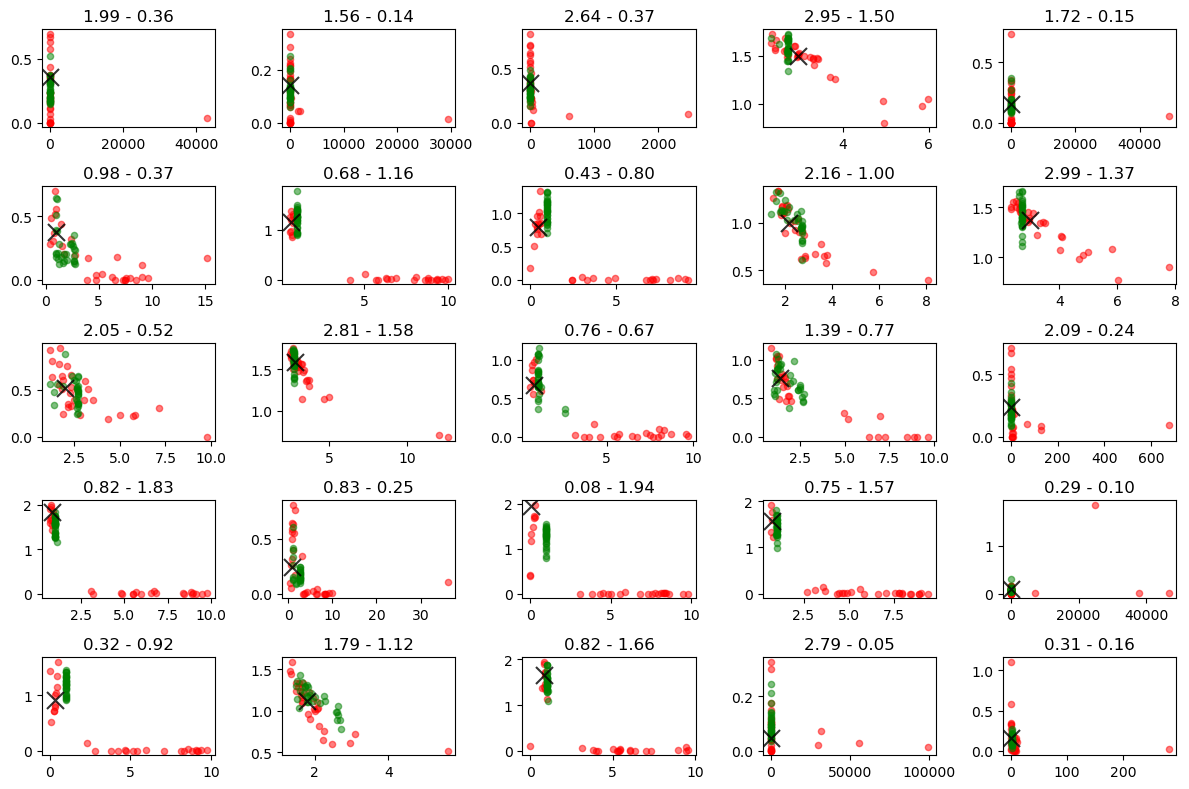

In [33]:
# With Likelihood flexible range
n_comb = 25
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*n_each):((i+1)*n_each),0], y = brown_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results for schlather with new parametr range

In [71]:
# Dataloader
exp = "exp_3"
path = f"../data/{exp}/data/"
model = "powexp"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 750)

In [72]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/cnn_{model}.pt"))

<All keys matched successfully>

In [73]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [74]:
pred_tf = retransform(pred)
param_tf = retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [48]:
# Brown metrics
get_metrics(pred_tf,param_tf)

RMSE: [0.91 0.31]
MAE: [0.7  0.21]
Bias: [ 0.5  -0.09]


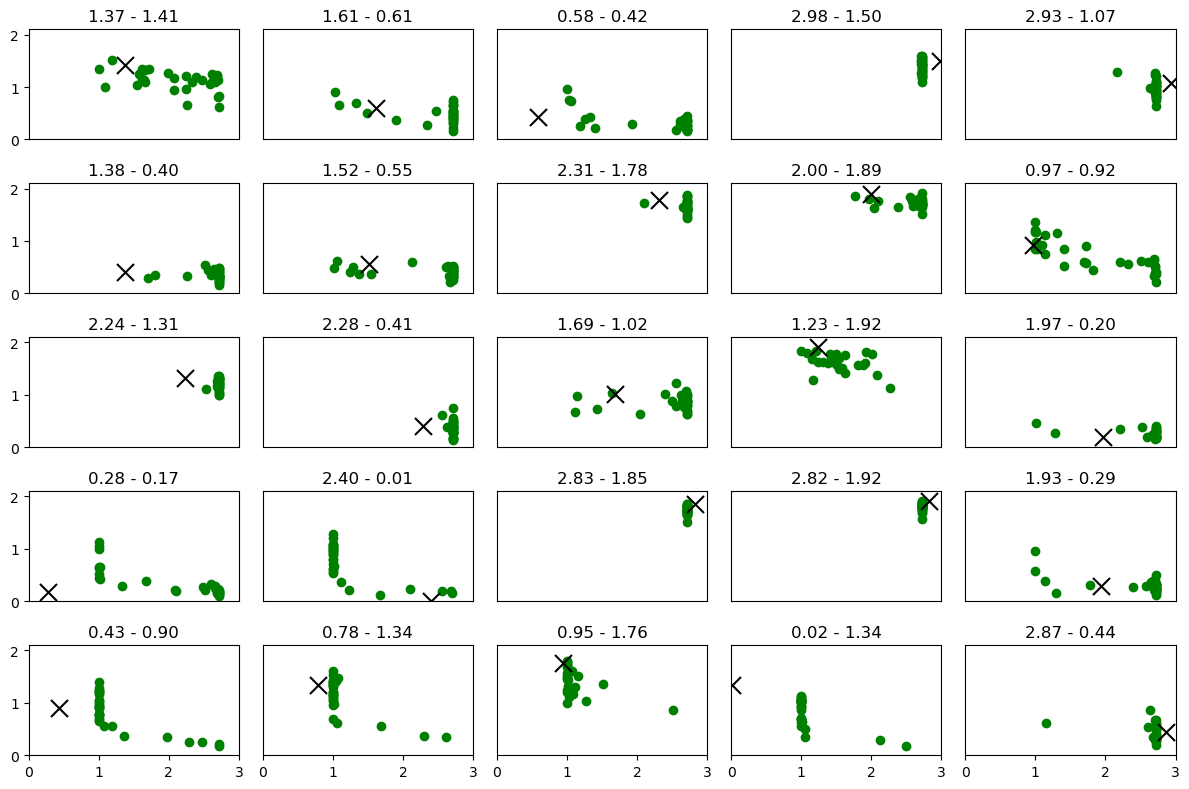

In [49]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2.1])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

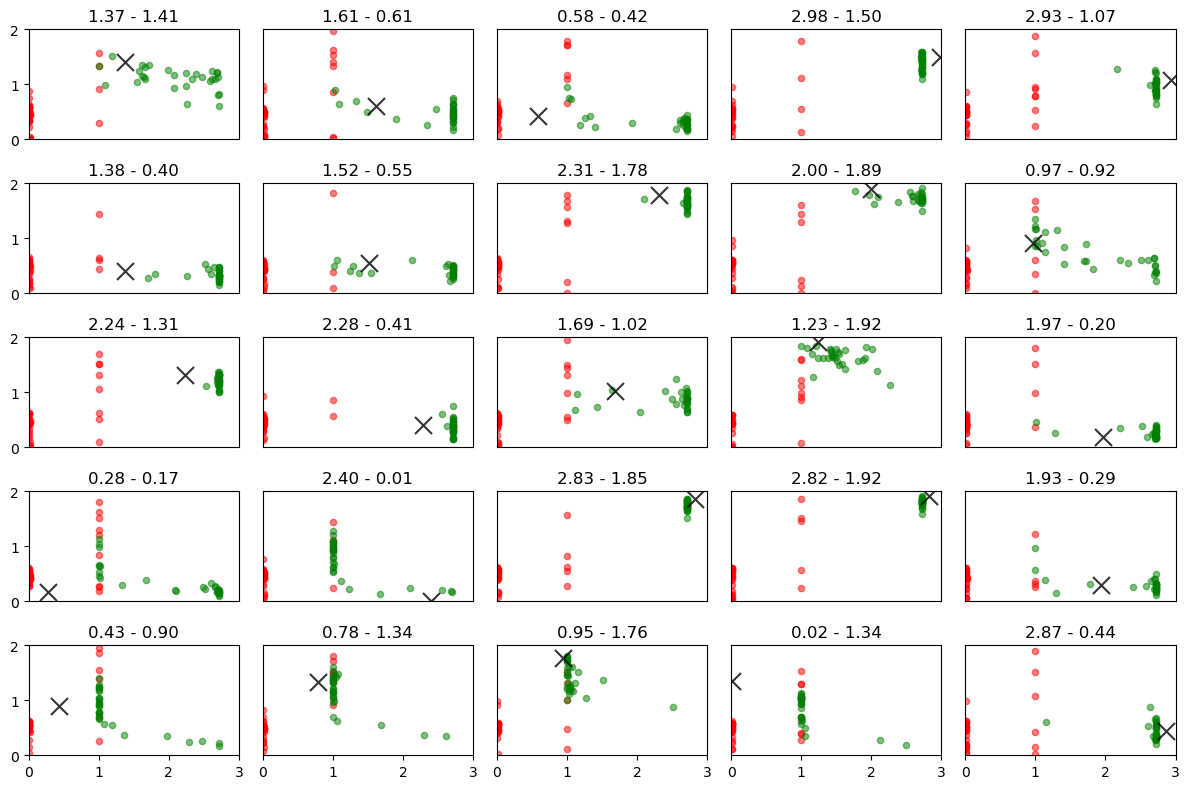

In [50]:
# With Likelihood fixed range

range_1 = 3
range_2 = 2
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*n_each):((i+1)*n_each),0], y = schlather_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_xlim([0,range_1])
    axs[i].set_ylim([0,range_2])
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

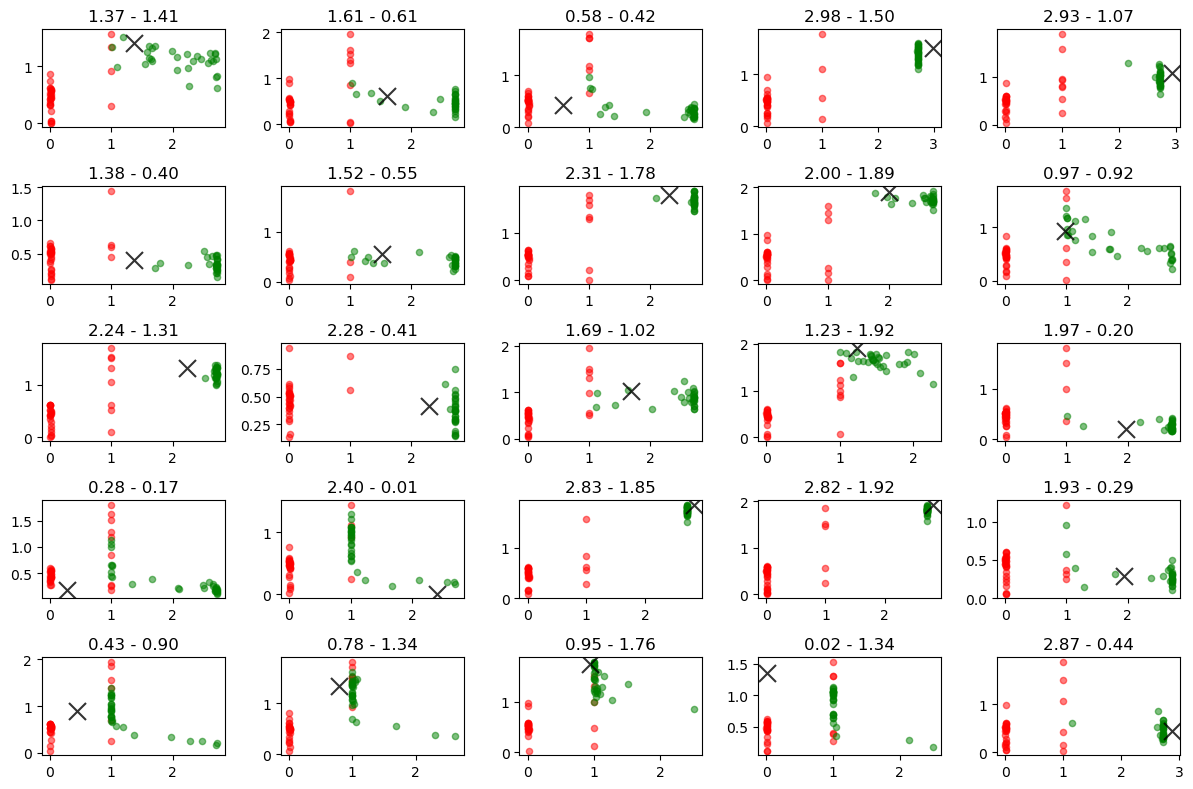

In [51]:
# With Likelihood flexible range
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*n_each):((i+1)*n_each),0], y = schlather_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)   
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results for aggregated model

In [7]:
# Dataloader
exp = "exp_3_1"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = test_loader(data_path = path, batch_size = 1500)

In [8]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/cnn.pt"))
net.eval()

CNN_pool(
  (conv_input): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=2304, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
  (output_1): Linear(in_features=256, out_features=1, bias=True)
  (output_2): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
for sample in dataloader:
    img, param, model = sample
    break 
pred = net(img).detach().numpy()
param = param.detach().numpy()
model = model.detach().numpy()

In [10]:
len(dataloader)

1

In [11]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:,0] = params[:,0]*(3-0.1)+0.1
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [12]:
def get_metrics(pred_tf, param_tf):
    rmse = np.sqrt(np.mean((np.power(pred_tf-param_tf,2)), axis = 0))
    mae = np.mean(np.abs(pred_tf-param_tf), axis = 0)
    bias = np.mean(pred_tf-param_tf, axis = 0)
    print(f"RMSE: {np.round(rmse,2)}")
    print(f"MAE: {np.round(mae,2)}")
    print(f"Bias: {np.round(bias,2)}")

In [13]:
pred_tf_full = retransform(pred)
param_tf_full = retransform(param)

In [14]:
# Brown metrics
get_metrics(pred_tf_full[model==0],param_tf_full[model==0])

RMSE: [0.61 0.17]
MAE: [0.46 0.13]
Bias: [0.13 0.02]


In [15]:
get_metrics(pred_tf_full[model==1],param_tf_full[model==1])

RMSE: [0.72 0.28]
MAE: [0.55 0.19]
Bias: [ 0.1  -0.04]


In [16]:
# Plot results
n_comb = 25
n_each = 30

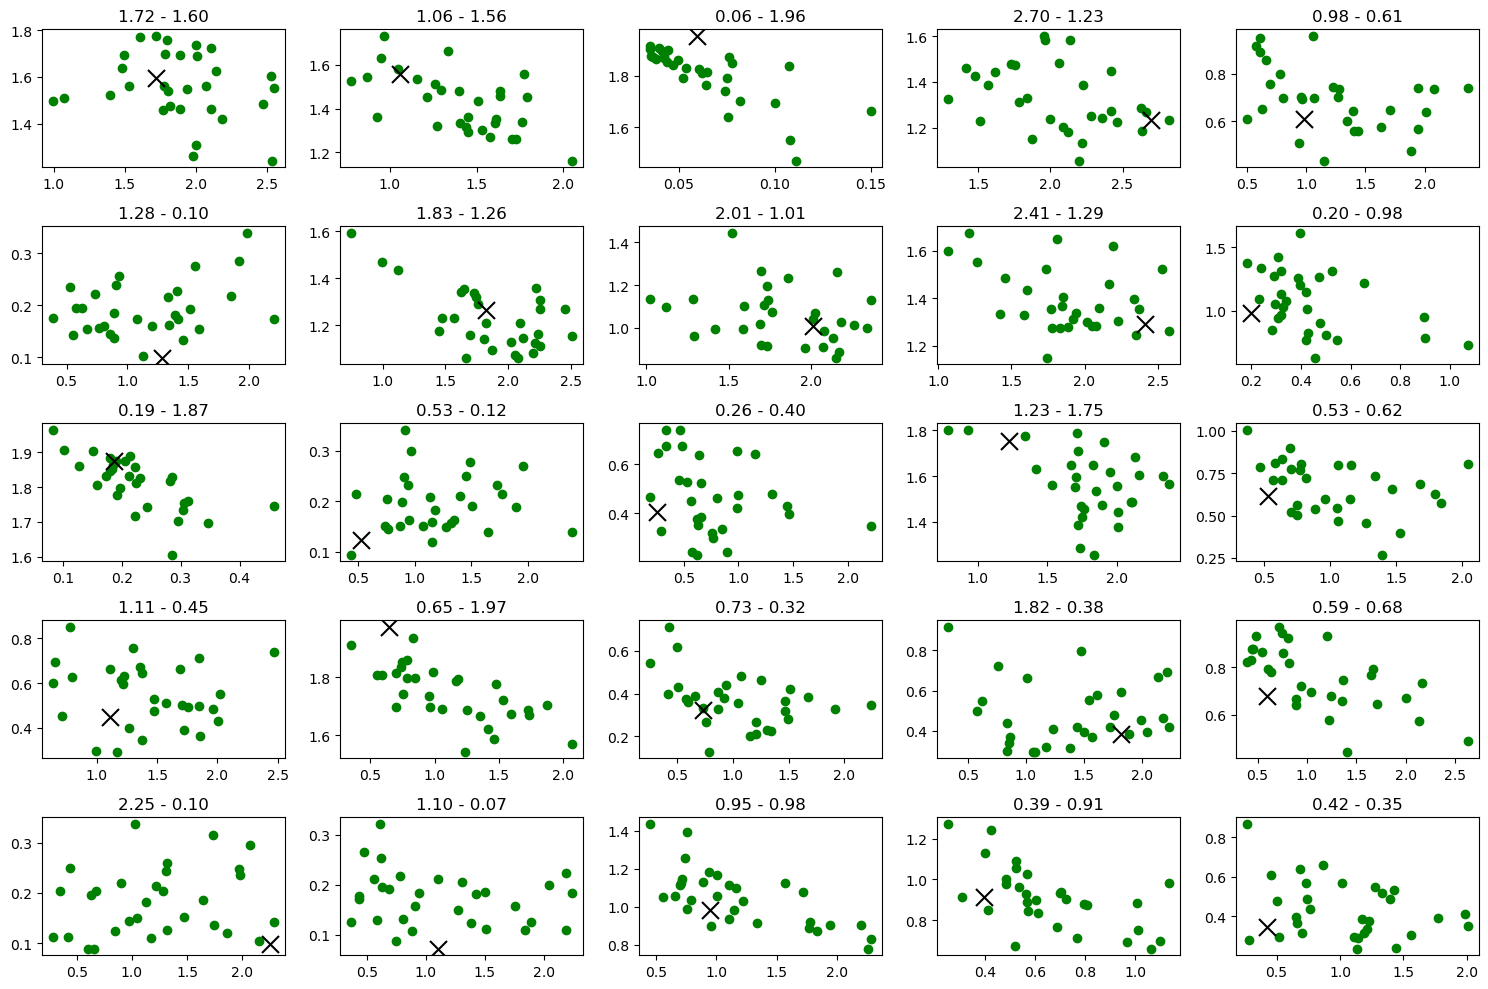

In [28]:
#Brown
pred_tf = pred_tf_full[model==0]
param_tf = param_tf_full[model==0]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

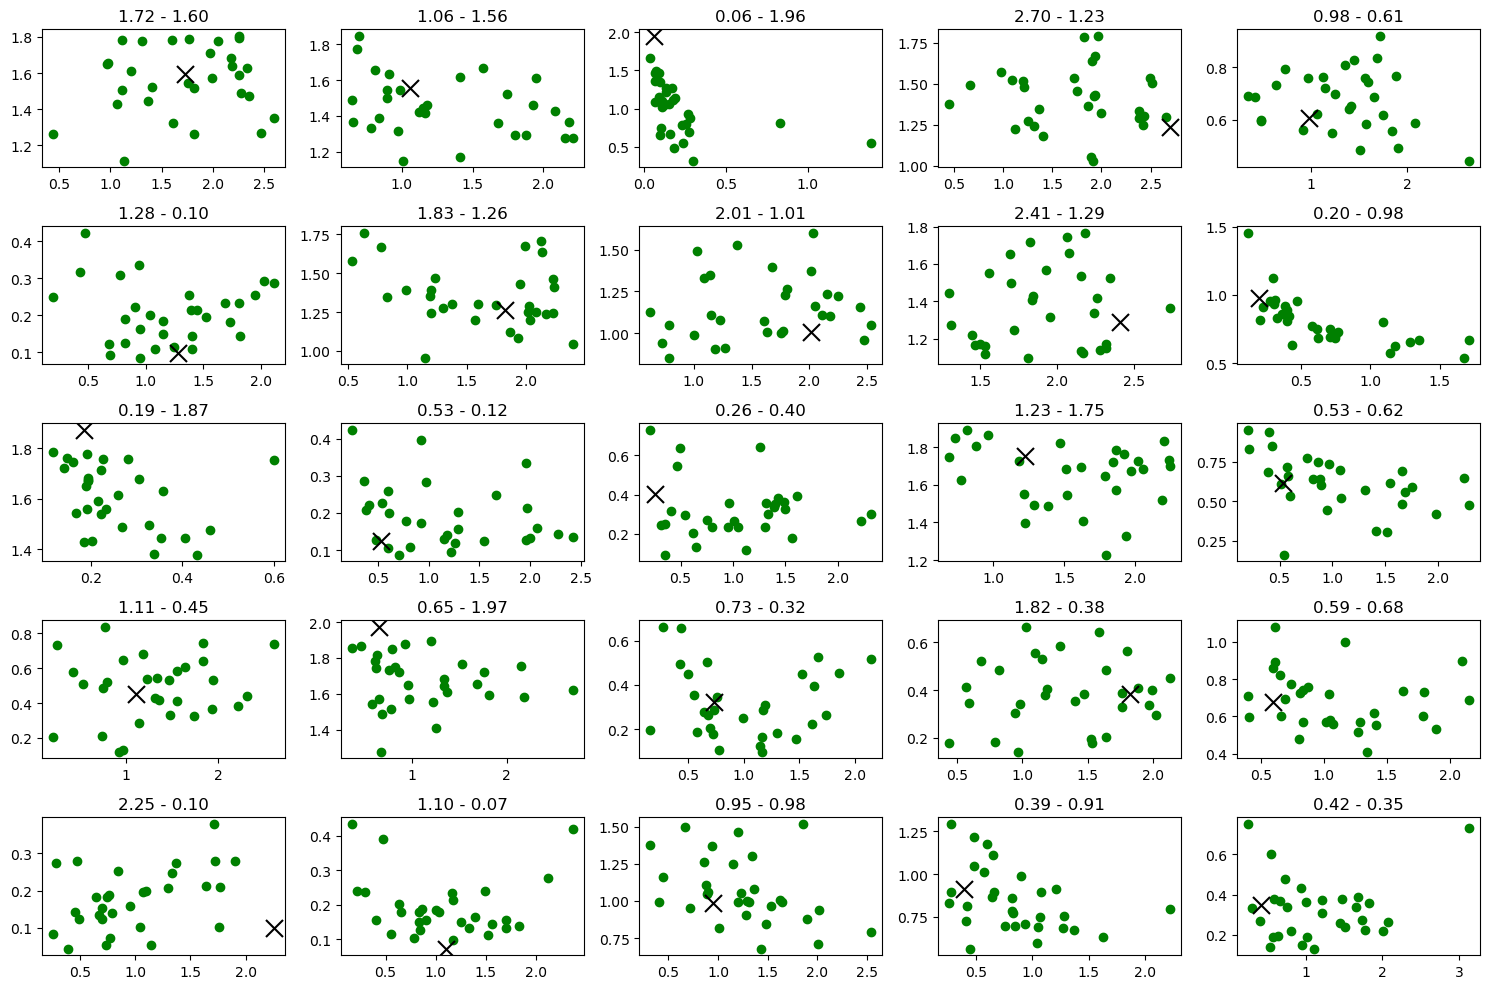

In [29]:
#Schlather
pred_tf = pred_tf_full[model==1]
param_tf = param_tf_full[model==1]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()